# Uncertainty Quantification Ensemble Demo (Advanced)

Content
1. [Introduction](#section1')
2. [Set up LLM and Prompts](#section2')
3. [Generate Responses and Confidence Scores](#section3')<br>
4. [Tune Parameters](#section4')
5. [Performance Evaluation](#section5')
6. [Scorer Definitions](#section6')

In [1]:
import warnings

import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

from uqlm.utils import load_example_dataset, math_postprocessor, plot_model_accuracies
from uqlm.quantifiers import UQEnsemble

warnings.filterwarnings("ignore")

/home/jupyter/.cache/pypoetry/virtualenvs/uqlm-g7jzkC-R-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-03-05 18:15:53.296157: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741198553.320653   20612 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741198553.328239   20612 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-05 18:15:53.353527: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU in

<a id='section1'></a>
## 1. Introduction

Ensemble UQ methods combine multiple individual scorers to provide a more robust and accurate uncertainty estimate. They offer high flexibility and customizability, allowing you to tailor the ensemble to specific use cases.

**Pros:**

*   ✅  **Highly Flexible:** Versatile and adaptable to various tasks and question types.
*   ✅  **Highly Customizable:** Ensemble weights can be tuned for optimal performance on a specific use case.

**Cons:**

*   ⚠️  **Requires More Setup:** Not quite "off-the-shelf"; requires some effort to configure and tune the ensemble.
*   ⚠️  **Best for Advanced Users:**  Optimizing the ensemble requires a deeper understanding of the individual scorers.

**Available Scorers:**

*   BS Detector ([Chen & Mueller, 2023](https://arxiv.org/abs/2308.16175))
*   Generalized Ensemble (uses any combination of black-box, white-box, and LLM-as-a-judge scorers)

<a id='section2'></a>
## 2. Set up LLM and Prompts

In [2]:
# Loaod example dataset (SVAMP)
svamp = (
    load_example_dataset("svamp")
    .rename(columns={"question_concat": "question", "Answer": "answer"})[
        ["question", "answer"]
    ]
    .head(100)
)
svamp.head()

Loading dataset - svamp...
Processing dataset...
Dataset ready!


,question,answer
0,There are 87 oranges and 290 bananas in Philip...,145
1,Marco and his dad went strawberry picking. Mar...,19
2,Edward spent $ 6 to buy 2 books each book cost...,3
3,Frank was reading through his favorite book. T...,198
4,There were 78 dollars in Olivia's wallet. She ...,63


In [3]:
svamp_tune = svamp.iloc[0:50]
svamp_test = svamp.iloc[51:100]

In [4]:
# Define prompts
MATH_INSTRUCTION = (
    "When you solve this math problem only return the answer with no additional text.\n"
)
tune_prompts = [MATH_INSTRUCTION + prompt for prompt in svamp_tune.question]
test_prompts = [MATH_INSTRUCTION + prompt for prompt in svamp_test.question]

In [5]:
# User to populate .env file with API credentials
import os
from dotenv import load_dotenv, find_dotenv
from langchain_openai import AzureChatOpenAI

load_dotenv(find_dotenv())
gpt = AzureChatOpenAI(
    deployment_name=os.getenv("DEPLOYMENT_NAME"),
    openai_api_key=os.getenv("API_KEY"),
    azure_endpoint=os.getenv("API_BASE"),
    openai_api_type=os.getenv("API_TYPE"),
    openai_api_version=os.getenv("API_VERSION"),
    temperature=1,  # User to set temperature
)

In [6]:
# Instantiate Gemini models
from langchain_google_vertexai import ChatVertexAI

gemini_pro = ChatVertexAI(model_name="gemini-pro")

Note that although we use `ChatVertexAI` and `AzureChatOpenAI` in this example, any [LangChain Chat Model](https://js.langchain.com/docs/integrations/chat/) may be used.

<a id='section3'></a>
## 3. Generate responses and confidence scores

#### `UQEnsemble()` - Ensemble of uncertainty quantifiers (class).

**Class Attributes:**
- `llm` (**BaseChatModel, default=None**) A langchain llm (`BaseChatModel`). User is responsible for specifying temperature and other relevant parameters to the constructor of their `BaseChatModel` object.
- `components` - (**List containing instances of BaseChatModel, LLMJudge, or elements of ["semantic_entropy", "mean_nli",
        "exact_match", "self_reflection", "bert_score", "bleurt_score", "cosine_similarity"], default=None**) Specifies which UQ components to include. If None, defaults to ["semantic_entropy", "mean_nli", "exact_match","self_reflection"]=
- `device` - (**str or torch.device input or torch.device object, default="cpu"**) Specifies the device that classifiers use for prediction. Set to "cuda" for classifiers to be able to leverage the GPU.
- `system_prompt` - (**str or None, default="You are a helpful assistant."**) Optional argument for user to provide custom system prompt
- `max_calls_per_min` - (**int, default=None**) Specifies how many api calls to make per minute to avoid a rate limit error. By default, no limit is specified.
- `use_n_param` (**bool, default=False**) Specifies whether to use `n` parameter for `BaseChatModel`. Not compatible with all `BaseChatModel` classes. If used, it speeds up the generation process substantially when `num_responses` is large.
- `postprocessor` - (**(str) -> str, default=None**) A class object to compute the self-reflection certainty score. If not provided, this method will use defined 'langchain_llm' with 0 temperature.
- `self_reflection_generator` - (**ResponseGenerator, default=None**) A class object to compute the self-reflection certainty score. If not provided, this method will use defined 'langchain_llm' with 0 temperature.
- `weights` - (**list of floats, default= None**) Specifies weight for each component in ensemble. If none, each component receives equal weight.
- `nli_model_name` (**str, default="microsoft/deberta-large-mnli"**) Specifies which NLI model to use. Must be acceptable input to `AutoTokenizer.from_pretrained()` and `AutoModelForSequenceClassification.from_pretrained()`

In [7]:
import torch

device = torch.device("cuda")  # use if GPU available
# device = None

In [8]:
components = [
    "match_score",  # Measures proportion of candidate responses that match original response (black-box)
    "noncontradiction_score",  # mean non-contradiction probability between candidate responses and original response (black-box)
    "normalized_probability",  # length-normalized joint token probability (white-box)
    gemini_pro,  # LLM-as-a-judge (self)
    gpt,  # LLM-as-a-judge (separate LLM)
]

uqe = UQEnsemble(
    llm=gemini_pro,
    device=device,
    max_calls_per_min=250,
    # postprocessor=math_postprocessor,
    use_n_param=False,  # Set True if using AzureChatOpenAI for faster generation
    components=components,
)

Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


`UQEnsemble.evaluate` - Generate responses and evaluate confidence scores on LLM responses for the provided prompts..

**Method Arguments:**
- `prompts` - (**list of str**) A list of input prompts for the model.
- `responses` - (**list of str, default=None**) A list of model responses for the prompts. If not provided, this method will generate responses for `self.llm`. 
- `multiple_responses` - (**list of list of str, default=None**) A list of multiple model responses, each element (multiple_responses[i]) is a list of str, containing multiple model responses for prompts[i]. If not provided, this method will generate responses for `self.llm`.
- `mr_temperature` - (**float, default=1**) The `temperature` parameter for llm model to generate multiple responses
- `num_responses` - (**int, default=5**) The number of multiple responses used to compute observed consistency.

**Returns:**
    `UQResult` containing data (prompts, responses, and confidence scores) and metadata

In [9]:
results = await uqe.evaluate(prompts=tune_prompts, num_responses=5, use_best=True)

Generating responses...
Generating candidate responses...
Computing confidence scores...
Generating LLMJudge scores...
Generating LLMJudge scores...
Computing confidence scores...


In [10]:
result_df = results.to_df()
result_df.head(5)

,prompt,response,multiple_responses,confidence_score,match_score,noncontradiction_score,normalized_probability,judge_1,judge_2
0,When you solve this math problem only return t...,145,"[145, 145, 145, 145, 145]",0.698637,1.0,1.000000,0.993186,0.0,0.5
1,When you solve this math problem only return t...,19 pounds,"[$19$, 19 pounds., 19, 19 pounds, 19]",0.445825,0.2,0.818286,0.210841,1.0,0.0
2,When you solve this math problem only return t...,$ 3.00,"[$3.00, 4, 3, $ 3.00, $3 \n]",0.581271,0.2,0.862477,0.843878,0.0,1.0
3,When you solve this math problem only return t...,198,"[198, 198, 198, 198, 198]",0.798186,1.0,1.000000,0.990932,0.0,1.0
4,When you solve this math problem only return t...,63,"[$63, 63 dollars, 63, 63 dollars., 63]",0.570754,0.4,0.964027,0.489743,0.0,1.0


<a id='section4'></a>
## 4. Tune Parameters

#### Tune parameters and reassess

`UQEnsemble.tune_params` - Tunes weights and threshold on a set of user-provided graded responses. 

**Method Arguments:**
- `correct_indicators` - (**list of bool**) A list of boolean indicators of whether self.original_responses are correct.
- `weight_bounds` - (**list of 2-tuples of floats, default = [(0,1), (0,1), (0,1), (0,1)]**) Bounds of parameters for weights for scipy minimize function. Order must correspond to order of self.components.
- `weights_objective` - (**{'fbeta_score', 'accuracy_score', 'balanced_accuracy_score', 'roc_auc', 'log_loss'}, default='roc_auc'**) Objective function for optimization of alpha and beta. Must match thresh_objective if one of 'fbeta_score',          
- `thresh_bounds` - (**tuple of floats, default=(0,1)**) Bounds to search for threshold
- `thresh_objective` - (**{'fbeta_score', 'accuracy_score', 'balanced_accuracy_score', 'roc_auc', 'log_loss'}, default='fbeta_score'**) Objective function for threshold optimization via grid search.
- `n_trials` - (**int, default=100**) Indicates how many candidates to search over with optuna optimizer
- `grid_search_alpha_beta` - (**bool, default=False**) Indicates whether to conduct grid search as optimization routine for alpha and beta
- `step_size` - (**float, default=0.01**) Indicates step size in grid search, if used
- `fscore_beta` - (**float, default=1**) Value of beta in fbeta_score   

**Returns:**
    Instance of UQEnsembleResult, containing data (prompts, responses, and confidence scores) and metadata (parameters, etc.)

In [11]:
# Populate correct answers and grade responses
correct_indicators = [
    math_postprocessor(r) == a
    for r, a in zip(result_df["response"], svamp_tune["answer"])
]

In [12]:
tuned_result = uqe.tune_params(
    correct_indicators=correct_indicators, weights_objective="roc_auc"
)

Optimizing weights...
Optimizing threshold with grid search...


In [13]:
# View optimized_weights
for i, weight in enumerate(uqe.weights):
    print(f"Weight for {uqe.component_names[i]}: {weight}")

Weight for match_score: 0.31101559912033366
Weight for noncontradiction_score: 0.28149817493332807
Weight for normalized_probability: 0.3174254003685539
Weight for judge_1: 0.006798364703485985
Weight for judge_2: 0.08326246087429848


<a id='section5'></a>
## 5. Evaluate Performance

To evaluate performance, we will generate responses and corresponding confidence scores on a holdout set using the tuned ensemble.

In [14]:
test_results = await uqe.evaluate(prompts=test_prompts, num_responses=5, use_best=True)

Generating responses...
Generating candidate responses...
Computing confidence scores...
Generating LLMJudge scores...
Generating LLMJudge scores...
Computing confidence scores...


In [15]:
test_result_df = test_results.to_df()
test_result_df["response_correct"] = [
    math_postprocessor(r) == a
    for r, a in zip(test_result_df["response"], svamp_test["answer"])
]
test_result_df.head(5)

,prompt,response,multiple_responses,confidence_score,match_score,noncontradiction_score,normalized_probability,judge_1,judge_2,response_correct
0,When you solve this math problem only return t...,1,"[1, 1, 1, 1, 1]",0.908257,1.0,1.000000,0.994699,0.0,0.0,True
1,When you solve this math problem only return t...,27,"[27, 27, 27, 27, 87]",0.801006,0.8,0.821439,0.989717,1.0,0.0,True
2,When you solve this math problem only return t...,4,"[4, 4, 4, 4, 4]",0.995645,1.0,1.000000,0.986279,1.0,1.0,True
3,When you solve this math problem only return t...,17,"[27, 17, 17, 17, 17]",0.563772,0.8,0.827284,0.258584,0.0,0.0,True
4,When you solve this math problem only return t...,16,"[16 \n, 16, 16, 16, 22\n]",0.730174,0.6,0.815858,0.967482,1.0,0.0,False


In [16]:
print(f"""Baseline LLM accuracy: {np.mean(test_result_df["response_correct"])}""")

Baseline LLM accuracy: 0.6530612244897959


Next we will plot filtered LLM accuracy at various confidence score thresholds. The idea is to measure the LLM's performance when we consider responses with confidence scores above a given threshold.

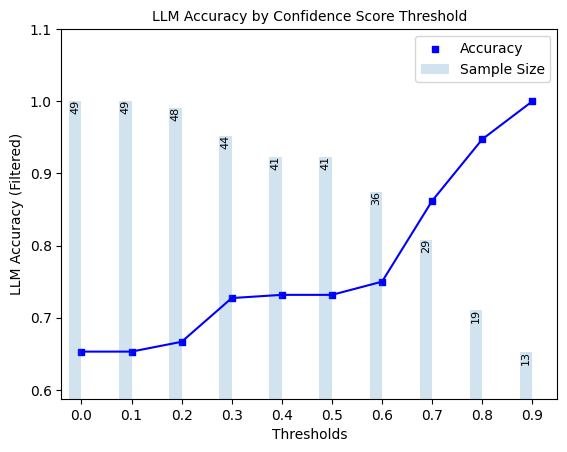

In [17]:
plot_model_accuracies(
    scores=test_result_df.confidence_score,
    correct_indicators=test_result_df.response_correct,
)

Lastly, we will compute the optimal threshold for binarizing confidence scores, using F1-score as the objective. Using this threshold, we can compute precision, recall, and F1-score for semantic entropy predictions of whether responses are correct.

In [18]:
# extract optimal threshold
best_threshold = uqe.thresh

# Define score vector and corresponding correct indicators (i.e. ground truth)
y_scores = test_result_df["confidence_score"]  # confidence score
correct_indicators = (
    test_result_df.response_correct
) * 1  # Whether responses is actually correct
y_pred = [
    (s > best_threshold) * 1 for s in y_scores
]  # predicts whether response is correct based on confidence score
print(f"Ensemble F1-optimal threshold: {best_threshold}")

Ensemble F1-optimal threshold: 0.4


In [19]:
# evaluate precision, recall, and f1-score of semantic entropy predictions of correctness
print(
    f"Ensemble precision: {precision_score(y_true=correct_indicators, y_pred=y_pred)}"
)
print(f"Ensemble recall: {recall_score(y_true=correct_indicators, y_pred=y_pred)}")
print(f"Ensemble f1-score: {f1_score(y_true=correct_indicators, y_pred=y_pred)}")

Ensemble precision: 0.7317073170731707
Ensemble recall: 0.9375
Ensemble f1-score: 0.821917808219178


<a id='section6'></a>
## 6. Scorer Definitions

### Black-Box Scorers
Black-Box UQ scorers exploit variation in LLM responses to the same prompt to measure semantic consistency. All scorers have outputs ranging from 0 to 1, with higher values indicating higher confidence. 

For a given prompt $x_i$, these approaches involves generating $m$ responses $\tilde{\mathbf{y}}_i = \{ \tilde{y}_{i1},...,\tilde{y}_{im}\}$, using a non-zero temperature, from the same prompt and comparing these responses to the original response $y_{i}$. We provide detailed descriptions of each below.

#### Exact Match Rate (`match_score`)
Exact Match Rate (EMR) computes the proportion of candidate responses that are identical to the original response.
$$     EMR(y_i; \tilde{\mathbf{y}}_i) = \frac{1}{m} \sum_{j=1}^m \mathbb{I}(y_i=\tilde{y}_{ij}). $$

For more on this scorer, refer to [Cole et al., 2023](https://arxiv.org/abs/2305.14613).

#### Non-Contradiction Probability (`noncontradiction_score`)
Non-contradiction probability (NCP) computes the mean non-contradiction probability estimated by a natural language inference (NLI) model. This score is formally defined as follows:

\begin{equation}
    NCP(y_i; \tilde{\mathbf{y}}_i) = \frac{1}{m} \sum_{j=1}^m(1 - p_j)
\end{equation}
where

\begin{equation}
    p_j = \frac{\eta(y_{i}, \tilde{y}_{ij}) + \eta(\tilde{y}_{ij},y_i)}{2}.
\end{equation}

Above, $\eta(\tilde{y}_{ij},y_i)$ denotes the contradiction probability estimated by the NLI model for response $y_i$ and candidate $\tilde{y}_{ij}$. For more on this scorer, refer to [Chen & Mueller, 2023](https://arxiv.org/abs/2308.16175), [Lin et al., 2025](https://arxiv.org/abs/2305.19187), or [Manakul et al., 2023](https://arxiv.org/abs/2303.08896).

#### Normalized Semantic Negentropy (`entropy_score`)
Normalized Semantic Negentropy (NSN) normalizes the standard computation of discrete semantic entropy to be increasing with higher confidence and have [0,1] support. In contrast to the EMR and NCP, semantic entropy does not distinguish between an original response and candidate responses. Instead, this approach computes a single metric value on a list of responses generated from the same prompt. Under this approach, responses are clustered using an NLI model based on mutual entailment. We consider the discrete version of SE, where the final set of clusters is defined  as follows:

\begin{equation}
    SE(y_i; \tilde{\mathbf{y}}_i) = - \sum_{C \in \mathcal{C}} P(C|y_i, \tilde{\mathbf{y}}_i)\log P(C|y_i, \tilde{\mathbf{y}}_i),
\end{equation}
where $P(C|y_i, \tilde{\mathbf{y}}_i)$ denotes the probability a randomly selected response $y \in \{y_i\} \cup \tilde{\mathbf{y}}_i $ belongs to cluster $C$, and $\mathcal{C}$ denotes the full set of clusters of $\{y_i\} \cup \tilde{\mathbf{y}}_i$.

To ensure that we have a normalized confidence score with $[0,1]$ support and with higher values corresponding to higher confidence, we implement the following normalization to arrive at \textit{Normalized Semantic Negentropy} (NSN):
\begin{equation}
    NSN(y_i; \tilde{\mathbf{y}}_i) = 1 - \frac{SE(y_i; \tilde{\mathbf{y}}_i)}{\log m},
\end{equation}
where $\log m$ is included to normalize the support.

#### BERTScore (`bert_score`)
Let a tokenized text sequence be denoted as $\textbf{t} = \{t_1,...t_L\}$ and the corresponding contextualized word embeddings as $\textbf{E} = \{\textbf{e}_1,...,\textbf{e}_L\}$, where $L$ is the number of tokens in the text. The BERTScore precision, recall, and F1-scores between two tokenized texts  $\textbf{t}, \textbf{t}'$ are respectively defined as follows:

\begin{equation}
    BertP(\textbf{t}, \textbf{t}') = \frac{1}{| \textbf{t}|} \sum_{t \in \textbf{t}} \max_{t' \in \textbf{t}'} \textbf{e} \cdot \textbf{e}'
\end{equation}

\begin{equation}
    BertR(\textbf{t}, \textbf{t}') = \frac{1}{| \textbf{t}'|} \sum_{t' \in \textbf{t}'} \max_{t \in \textbf{t}} \textbf{e} \cdot \textbf{e}'
\end{equation}

\begin{equation}
    BertF(\textbf{t}, \textbf{t}') = 2\frac{ BertP(\textbf{t}, \textbf{t}')  BertR(\textbf{t}, \textbf{t}')}{BertPr(\textbf{t}, \textbf{t}')  + BertRec(\textbf{t}, \textbf{t}')},
\end{equation}
where $e, e'$ respectively correspond to $t, t'$. We compute our BERTScore-based confidence scores as follows:
\begin{equation}
    BertConfidence(y_i; \tilde{\mathbf{y}}_i) = \frac{1}{m} \sum_{j=1}^m BertF(y_i, \tilde{y}_{ij}),
\end{equation}
i.e. the average BERTScore F1 across pairings of the original response with all candidate responses. For more on BERTScore, refer to [Zheng et al., 2020](https://arxiv.org/abs/1904.09675).

#### BLEURT (`bleurt_score`)
In contrast to the aforementioned scorers, BLEURT is specifically pre-trained and fine-tuned to learn human judgments of text similarity.\footnote{We use the recommended BLEURT checkpoint of \texttt{BLEURT-20}. Our BLEURT confidence score is the average BLEURT value across pairings of the original response with all candidate responses:

\begin{equation}
    BLEURTConfidence(y_i; \tilde{\mathbf{y}}_i) = \frac{1}{m} \sum_{j=1}^m BLEURT(y_i, \tilde{y}_{ij}).
\end{equation}

For more on this scorer, refer to [Sellam et al., 2020](https://arxiv.org/abs/2004.04696).


#### Normalized Cosine Similarity (`cosine_scorer`)
This scorer leverages a sentence transformer to map LLM outputs to an embedding space and measure similarity using those sentence embeddings. Let $V: \mathcal{Y} \xrightarrow{} \mathbb{R}^d$ denote the sentence transformer, where $d$ is the dimension of the embedding space. The average cosine similarity across pairings of the original response with all candidate responses is given as follows:

\begin{equation}
    CS(y_i; \tilde{\mathbf{y}}_i) = \frac{1}{m} \sum_{i=1}^m   \frac{\mathbf{V}(y_i) \cdot \mathbf{V}(\tilde{y}_{ij}) }{ \lVert \mathbf{V}(y_i) \rVert \lVert \mathbf{V}(\tilde{y}_{ij}) \rVert}.
\end{equation}

To ensure a standardized support of $[0, 1]$, we normalize cosine similarity to obtain confidence scores as follows:

\begin{equation}
    NCS(y_i; \tilde{\mathbf{y}}_i) = \frac{CS(y_i; \tilde{\mathbf{y}}_i) + 1}{2}.
\end{equation}


### White-Box UQ Scorers
White-box UQ scorers leverage token probabilities of the LLM's generated response to quantify uncertainty. All scorers have outputs ranging from 0 to 1, with higher values indicating higher confidence. We define two white-box UQ scorers below.

#### Length-Normalized Token Probability (`normalized_probability`)
Let the tokenization LLM response $y_i$ be denoted as $\{t_1,...,t_{L_i}\}$, where $L_i$ denotes the number of tokens the response. Length-normalized token probability (LNTP) computes a length-normalized analog of joint token probability:

\begin{equation}
    LNTP(y_i) = \prod_{t \in y_i}  p_t^{L_i},
\end{equation}
where $p_t$ denotes the token probability for token $t$. Note that this score is equivalent to the geometric mean of token probabilities for response $y_i$. For more on this scorer, refer to [Malinin & Gales, 2021](https://arxiv.org/pdf/2002.07650).


#### Minimum Token Probability (`min_probability`)
Minimum token probability (MTP) uses the minimum among token probabilities for a given responses as a confidence score:

\begin{equation}
    MTP(y_i) = \min_{t \in y_i}  p_t,
\end{equation}
where $t$ and $p_t$ follow the same definitions as above. For more on this scorer, refer to [Manakul et al., 2023](https://arxiv.org/abs/2303.08896).

### LLM-as-a-Judge Scorers
Under the LLM-as-a-Judge approach, either the same LLM that was used for generating the original responses or a different LLM is asked to form a judgment about a pre-generated response. Below, we define two LLM-as-a-Judge scorer templates. 
#### Categorical Judge Template (`true_false_uncertain`)
We follow the approach proposed by [Chen & Mueller, 2023](https://arxiv.org/abs/2308.16175) in which an LLM is instructed to score a question-answer concatenation as either  *incorrect*, *uncertain*, or *correct* using a carefully constructed prompt. These categories are respectively mapped to numerical scores of 0, 0.5, and 1. We denote the LLM-as-a-judge scorers as $J: \mathcal{Y} \xrightarrow[]{} \{0, 0.5, 1\}$. Formally, we can write this scorer function as follows:

\begin{equation}
J(y_i) = \begin{cases}
    0 & \text{LLM states response is incorrect} \\
    0.5 & \text{LLM states that it is uncertain} \\
    1 & \text{LLM states response is correct}.
\end{cases}
\end{equation}

#### Continuous Judge Template (`continuous`)
For the continuous template, the LLM is asked to directly score a question-answer concatenation's correctness on a scale of 0 to 1. 